In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0-beta1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.16.2
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir =  os.path.join('chap9_save_graph_def_and_weights')
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
# output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")
output_model_file = os.path.join(logdir, "fashion_mnist_weights.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True, 
                                    save_weights_only = True),                                    
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.5358 - accuracy: 0.8124 - val_loss: 0.4179 - val_accuracy: 0.8486
Epoch 2/10
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3937 - accuracy: 0.8576 - val_loss: 0.3837 - val_accuracy: 0.8586
Epoch 3/10
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3546 - accuracy: 0.8735 - val_loss: 0.3539 - val_accuracy: 0.8730
Epoch 4/10
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3291 - accuracy: 0.8801 - val_loss: 0.3350 - val_accuracy: 0.8788
Epoch 5/10
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3094 - accuracy: 0.8879 - val_loss: 0.3266 - val_accuracy: 0.8806
Epoch 6/10
55000/55000 [==============================] - 3s 48us/sample - loss: 0.2939 - accuracy: 0.8936 - val

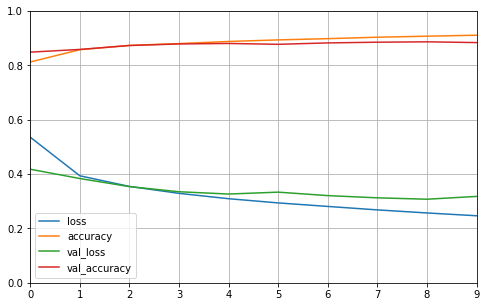

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [7]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.3609 - accuracy: 0.8699


[0.3608777020454407, 0.8699]

In [8]:
# loaded_model = keras.models.load_model(output_model_file)
# loaded_model.evaluate(x_test_scaled, y_test)

#### 只有weights 的话需要预定义模型结构

In [10]:
model.load_weights(output_model_file)
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 32us/sample - loss: 0.3450 - accuracy: 0.8767


[0.3449716807484627, 0.8767]

In [ ]:
# evalute结果不一致
# 原因可能是因为 save_best_only

In [12]:
model.save_weights(os.path.join(logdir, "fashion_mnist_weights_2.h5"))

In [14]:
output_model_file_2 = os.path.join(logdir, "fashion_mnist_weights_2.h5")
model.load_weights(output_model_file_2)
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 33us/sample - loss: 0.3450 - accuracy: 0.8767


[0.3449716807484627, 0.8767]